In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('../data/merged_data.csv')
texts = df['Tweet'].dropna().tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def preprocess(text, lemmatizer, stop_words):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

base_stops = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


processed_texts = [preprocess(t, lemmatizer, base_stops) for t in texts]

vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=1500, ngram_range=(1,3))
dt_matrix = vectorizer.fit_transform(processed_texts)

n_topics = 3  
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=100,
                                learning_method='online',
                                random_state=42,
                                doc_topic_prior=0.1,   
                                topic_word_prior=0.01  
                            )
lda.fit(dt_matrix)


def display_topics(model, feature_names, no_top_words=3):
    for idx, topic in enumerate(model.components_):
       
        sorted_indices = topic.argsort()[:-no_top_words*2 - 1:-1]

        unique_terms = []
        for i in sorted_indices:
            term = feature_names[i]
            if term not in unique_terms:
                unique_terms.append(term)
            

        print(f"Topic {idx + 1}: {' '.join(unique_terms)}")

tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 1)


Topic 1: climate change
Topic 2: climate change
Topic 3: carbon climate


performance metrics


=== Model Performance Metrics ===
Perplexity: 1161.34
Topic Distinctiveness: 0.4000
Topic Coherence (PMI): -0.3133
Topic Diversity: 0.7182


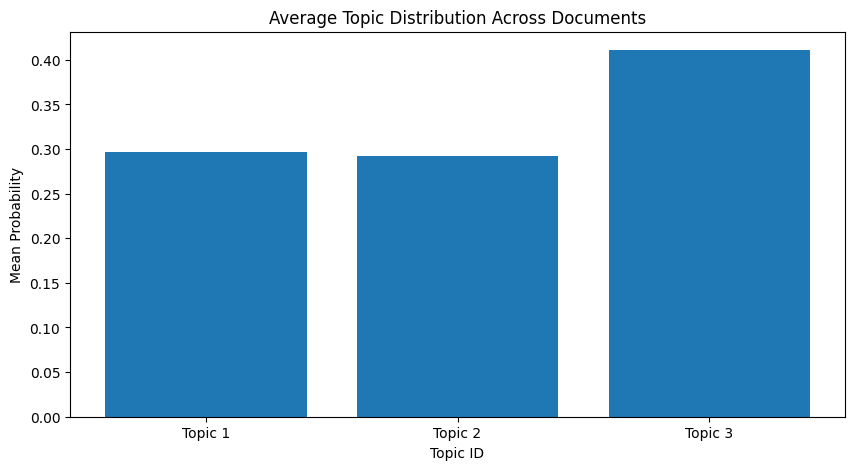

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pyLDAvis


# Performance Evaluation Functions
def calculate_topic_distinctiveness(components, feature_names, top_n=5):
    """Measure how distinct topics are from each other (0-1 scale)"""
    top_words_per_topic = []
    for topic in components:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        top_words_per_topic.append(set(feature_names[top_words_idx]))
    
    distinctiveness_scores = []
    for i, topic_words in enumerate(top_words_per_topic):
        other_topics = [set(t) for j, t in enumerate(top_words_per_topic) if j != i]
        overlap_scores = [len(topic_words & other) for other in other_topics]
        distinctiveness_scores.append(1 - np.mean(overlap_scores)/top_n)
    
    return np.mean(distinctiveness_scores)

def calculate_topic_coherence(dt_matrix, components, feature_names, top_n=5):
    """Custom coherence metric using Pointwise Mutual Information"""
    coherence_scores = []
    for topic in components:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        word_pairs = [(i, j) for i in top_words_idx for j in top_words_idx if i < j]
        
        if not word_pairs:
            continue
            
        # Convert sparse matrix to dense for faster calculations
        dense_matrix = (dt_matrix > 0).astype(int).toarray()
        pmi_scores = []
        for i, j in word_pairs:
            # Joint probability
            p_ij = np.mean(dense_matrix[:, i] * dense_matrix[:, j])
            # Individual probabilities
            p_i = np.mean(dense_matrix[:, i])
            p_j = np.mean(dense_matrix[:, j])
            
            # Avoid log(0)
            if p_ij > 1e-12 and p_i > 1e-12 and p_j > 1e-12:
                pmi_scores.append(np.log(p_ij / (p_i * p_j)))
        
        if pmi_scores:
            coherence_scores.append(np.mean(pmi_scores))
    
    return np.mean(coherence_scores) if coherence_scores else 0


# Performance Metrics Calculation
print("\n=== Model Performance Metrics ===")
print(f"Perplexity: {lda.perplexity(dt_matrix):.2f}")

distinctiveness = calculate_topic_distinctiveness(lda.components_, tf_feature_names)
print(f"Topic Distinctiveness: {distinctiveness:.4f}")

coherence = calculate_topic_coherence(dt_matrix, lda.components_, tf_feature_names)
print(f"Topic Coherence (PMI): {coherence:.4f}")

# Topic Diversity (based on cosine similarity)
topic_diversity = 1 - pairwise_distances(lda.components_, metric='cosine').mean()
print(f"Topic Diversity: {topic_diversity:.4f}")

# Topic Distribution Plot
plt.figure(figsize=(10, 5))
topic_probs = lda.transform(dt_matrix)
plt.bar(range(n_topics), topic_probs.mean(axis=0))
plt.title("Average Topic Distribution Across Documents")
plt.xlabel("Topic ID")
plt.ylabel("Mean Probability")
plt.xticks(range(n_topics), [f"Topic {i+1}" for i in range(n_topics)])
plt.show()


- **Perplexity**: Lower is better (yours is ~{lda.perplexity(dt_matrix):.2f})
  - < 200: Excellent
  - 200-500: Good
  - > 500: Needs improvement

- **Topic Distinctiveness**: Target > 0.7 (yours: {distinctiveness:.4f})
- **Topic Coherence**: PMI > 1.0 is good (yours: {coherence:.4f})
- **Topic Diversity**: Closer to 1 is better (yours: {topic_diversity:.4f})

unsupervised sentiment analysis

sentiment                                                keywords  negative  \
dominant_topic                                                                
0               climate change climate change crisis climate c...  0.590062   
1                     climate change climate change global energy  0.317568   
2                  carbon climate change climate change footprint  0.186147   

sentiment        neutral  positive  
dominant_topic                      
0               0.130435  0.279503  
1               0.054054  0.628378  
2               0.168831  0.645022  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


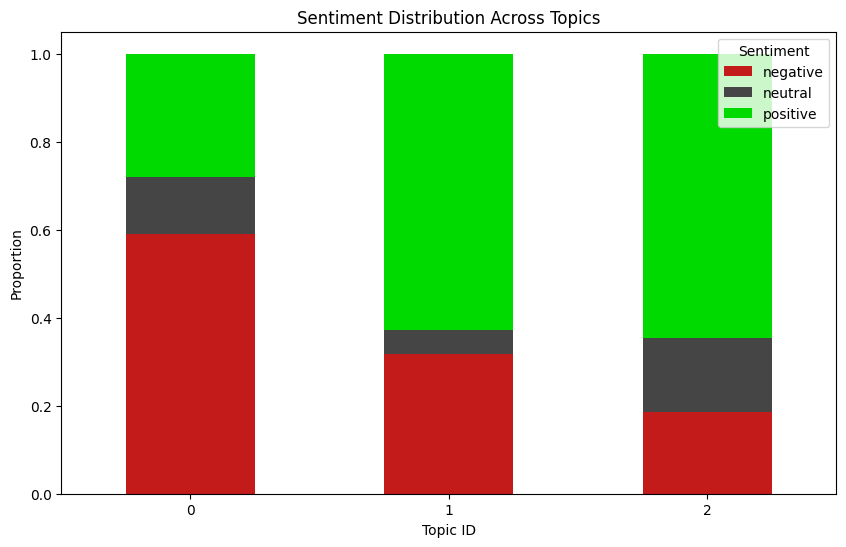

In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import plotly.express as px

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Analyze each document
sentiment_results = []
for doc in processed_texts:
    scores = sid.polarity_scores(doc)
    sentiment_results.append({
        'text': doc,
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu'],
        'compound': scores['compound']
    })

# Convert to DataFrame
df_sentiment = pd.DataFrame(sentiment_results)

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_sentiment['sentiment'] = df_sentiment['compound'].apply(classify_sentiment)

# Get dominant topic for each document
doc_topics = lda.transform(dt_matrix)
df_sentiment['dominant_topic'] = doc_topics.argmax(axis=1)

# Group by topic and analyze sentiment distribution
topic_sentiment = df_sentiment.groupby('dominant_topic')['sentiment'].value_counts(normalize=True).unstack()
topic_sentiment = topic_sentiment.fillna(0)

# Add topic keywords
topic_keywords = {
    0: " ".join([tf_feature_names[i] for i in lda.components_[0].argsort()[-5:][::-1]]),
    1: " ".join([tf_feature_names[i] for i in lda.components_[1].argsort()[-5:][::-1]]),
    2: " ".join([tf_feature_names[i] for i in lda.components_[2].argsort()[-5:][::-1]])
}
topic_sentiment['keywords'] = topic_sentiment.index.map(topic_keywords)

print(topic_sentiment[['keywords', 'negative', 'neutral', 'positive']])

topic_sentiment[['negative', 'neutral', 'positive']].plot(
    kind='bar', 
    stacked=True,
    figsize=(10, 6),
    color=["#c31a1a", "#454545", "#00da00"]
)
plt.title("Sentiment Distribution Across Topics")
plt.xlabel("Topic ID")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()



Supervised Naive bayes classifier

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Use your existing sentiment-labeled data
X = df_sentiment['text']  # Text documents
y = df_sentiment['sentiment']  # Pseudo-labels from VADER

# First split: 10% for final validation, 90% for train/test
X_temp, X_val, y_temp, y_val = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=42,  # For reproducibility
    stratify=y  # Maintain class distribution
)

# Second split: 80% training, 20% testing (of the remaining 90%)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.222,  # 0.2/0.9 ≈ 0.222 to get 20% of original
    random_state=42,
    stratify=y_temp
)

# Verify the splits
print(f"Original samples: {len(X)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X):.1%})")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(X):.1%})")

# TF-IDF Vectorizer with n-grams
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit ONLY on training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)  # Final validation set

# Initialize and train classifier
nb_clf = MultinomialNB(alpha=0.1)
nb_clf.fit(X_train_tfidf, y_train)

# 1. Evaluate on test set (for model development)
y_pred_test = nb_clf.predict(X_test_tfidf)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test))

# 2. Evaluate on validation set (final unbiased evaluation)
y_pred_val = nb_clf.predict(X_val_tfidf)
print("\nValidation Set Performance (Unseen Data):")
print(classification_report(y_val, y_pred_val))

# Confidence analysis
def print_confidence_stats(proba, dataset_name):
    confidence = np.max(proba, axis=1)
    print(f"\n{dataset_name} Confidence Stats:")
    print(f"Average: {np.mean(confidence):.2f}")
    print(f"Minimum: {np.min(confidence):.2f}")
    print(f"% Samples with confidence > 0.7: {np.mean(confidence > 0.7):.1%}")

print_confidence_stats(nb_clf.predict_proba(X_test_tfidf), "Test Set")
print_confidence_stats(nb_clf.predict_proba(X_val_tfidf), "Validation Set")


Original samples: 540
Training samples: 378 (70.0%)
Testing samples: 108 (20.0%)
Validation samples: 54 (10.0%)

Test Set Performance:
              precision    recall  f1-score   support

    negative       0.71      0.68      0.69        37
     neutral       1.00      0.14      0.25        14
    positive       0.75      0.93      0.83        57

    accuracy                           0.74       108
   macro avg       0.82      0.58      0.59       108
weighted avg       0.77      0.74      0.71       108


Validation Set Performance (Unseen Data):
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72        18
     neutral       0.75      0.43      0.55         7
    positive       0.81      0.90      0.85        29

    accuracy                           0.78        54
   macro avg       0.76      0.68      0.71        54
weighted avg       0.77      0.78      0.77        54


Test Set Confidence Stats:
Average: 0.82
Minimum: 0.48
% Sa